<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:14:05] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


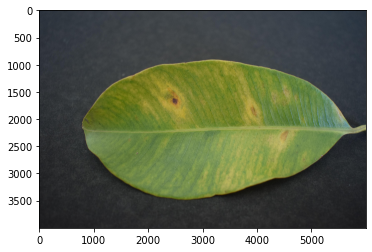

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

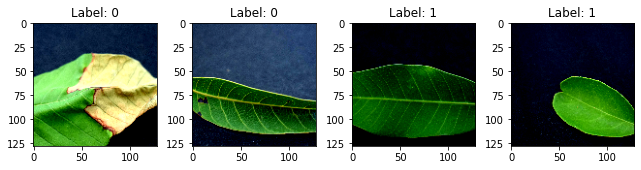

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:11] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:13] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2617512373305697 samples/sec                   batch loss = 1.0717246532440186 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.266855523394806 samples/sec                   batch loss = 0.7489998936653137 | accuracy = 0.375


Epoch[1] Batch[15] Speed: 1.2729578061309539 samples/sec                   batch loss = 0.6057503819465637 | accuracy = 0.43333333333333335


Epoch[1] Batch[20] Speed: 1.2681770203265517 samples/sec                   batch loss = 0.7642253041267395 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.269996087187663 samples/sec                   batch loss = 0.4860624074935913 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.268373948447088 samples/sec                   batch loss = 0.43973737955093384 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.268789961132133 samples/sec                   batch loss = 0.7175085544586182 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2674423875264182 samples/sec                   batch loss = 0.42677539587020874 | accuracy = 0.59375


Epoch[1] Batch[45] Speed: 1.2756087689769737 samples/sec                   batch loss = 0.7786755561828613 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.2727357001902062 samples/sec                   batch loss = 0.5394721031188965 | accuracy = 0.615


Epoch[1] Batch[55] Speed: 1.2723439205161204 samples/sec                   batch loss = 0.3031505346298218 | accuracy = 0.6272727272727273


Epoch[1] Batch[60] Speed: 1.2695458509230177 samples/sec                   batch loss = 1.3379578590393066 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2709785848509516 samples/sec                   batch loss = 0.832070529460907 | accuracy = 0.5961538461538461


Epoch[1] Batch[70] Speed: 1.2761439756655704 samples/sec                   batch loss = 0.5915692448616028 | accuracy = 0.6


Epoch[1] Batch[75] Speed: 1.2694165571190752 samples/sec                   batch loss = 0.40397384762763977 | accuracy = 0.6033333333333334


Epoch[1] Batch[80] Speed: 1.2713113350377896 samples/sec                   batch loss = 0.5112689733505249 | accuracy = 0.6125


Epoch[1] Batch[85] Speed: 1.2737565791941143 samples/sec                   batch loss = 0.7362346053123474 | accuracy = 0.6088235294117647


Epoch[1] Batch[90] Speed: 1.2670586439633706 samples/sec                   batch loss = 0.8020136952400208 | accuracy = 0.6138888888888889


Epoch[1] Batch[95] Speed: 1.2709465229071961 samples/sec                   batch loss = 1.3468605279922485 | accuracy = 0.6157894736842106


Epoch[1] Batch[100] Speed: 1.2684155662079148 samples/sec                   batch loss = 0.3101230263710022 | accuracy = 0.615


Epoch[1] Batch[105] Speed: 1.2648066300133536 samples/sec                   batch loss = 0.4705533981323242 | accuracy = 0.611904761904762


Epoch[1] Batch[110] Speed: 1.2656052275302896 samples/sec                   batch loss = 0.6466324329376221 | accuracy = 0.6181818181818182


Epoch[1] Batch[115] Speed: 1.266239193481605 samples/sec                   batch loss = 0.3884940445423126 | accuracy = 0.6195652173913043


Epoch[1] Batch[120] Speed: 1.2698289291416274 samples/sec                   batch loss = 0.9736875891685486 | accuracy = 0.6208333333333333


Epoch[1] Batch[125] Speed: 1.2682119145225441 samples/sec                   batch loss = 1.021394968032837 | accuracy = 0.62


Epoch[1] Batch[130] Speed: 1.2657680284556863 samples/sec                   batch loss = 0.35986804962158203 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.267507692056636 samples/sec                   batch loss = 0.35589247941970825 | accuracy = 0.6240740740740741


Epoch[1] Batch[140] Speed: 1.2686892182465968 samples/sec                   batch loss = 0.5578159093856812 | accuracy = 0.6267857142857143


Epoch[1] Batch[145] Speed: 1.270571720377551 samples/sec                   batch loss = 0.9974035024642944 | accuracy = 0.6258620689655172


Epoch[1] Batch[150] Speed: 1.2669024946187353 samples/sec                   batch loss = 0.33558738231658936 | accuracy = 0.63


Epoch[1] Batch[155] Speed: 1.2694460445464877 samples/sec                   batch loss = 0.7891356348991394 | accuracy = 0.6225806451612903


Epoch[1] Batch[160] Speed: 1.2681135638256462 samples/sec                   batch loss = 1.0139440298080444 | accuracy = 0.6203125


Epoch[1] Batch[165] Speed: 1.2684471169755989 samples/sec                   batch loss = 0.735779345035553 | accuracy = 0.6181818181818182


Epoch[1] Batch[170] Speed: 1.2678247348763765 samples/sec                   batch loss = 0.37312543392181396 | accuracy = 0.6191176470588236


Epoch[1] Batch[175] Speed: 1.2680467592363398 samples/sec                   batch loss = 0.7920385599136353 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2691341427335043 samples/sec                   batch loss = 1.026870608329773 | accuracy = 0.6138888888888889


Epoch[1] Batch[185] Speed: 1.2661582527256163 samples/sec                   batch loss = 0.8603733777999878 | accuracy = 0.6094594594594595


Epoch[1] Batch[190] Speed: 1.2280533939058826 samples/sec                   batch loss = 1.3234012126922607 | accuracy = 0.6105263157894737


Epoch[1] Batch[195] Speed: 1.2756671580346266 samples/sec                   batch loss = 0.30199456214904785 | accuracy = 0.6141025641025641


Epoch[1] Batch[200] Speed: 1.2769231366405853 samples/sec                   batch loss = 1.2850043773651123 | accuracy = 0.61


Epoch[1] Batch[205] Speed: 1.2795040984481723 samples/sec                   batch loss = 0.8677522540092468 | accuracy = 0.6109756097560975


Epoch[1] Batch[210] Speed: 1.2719875806724064 samples/sec                   batch loss = 0.7302128076553345 | accuracy = 0.6107142857142858


Epoch[1] Batch[215] Speed: 1.27384652203452 samples/sec                   batch loss = 0.3587546944618225 | accuracy = 0.6151162790697674


Epoch[1] Batch[220] Speed: 1.273528974176016 samples/sec                   batch loss = 0.3561449348926544 | accuracy = 0.6193181818181818


Epoch[1] Batch[225] Speed: 1.268969515020421 samples/sec                   batch loss = 0.39967483282089233 | accuracy = 0.6177777777777778


Epoch[1] Batch[230] Speed: 1.2715911533502362 samples/sec                   batch loss = 0.7156174182891846 | accuracy = 0.6173913043478261


Epoch[1] Batch[235] Speed: 1.2690185628922328 samples/sec                   batch loss = 0.749452531337738 | accuracy = 0.6138297872340426


Epoch[1] Batch[240] Speed: 1.2700445414488162 samples/sec                   batch loss = 0.7003047466278076 | accuracy = 0.615625


Epoch[1] Batch[245] Speed: 1.2695248124699827 samples/sec                   batch loss = 0.5464929938316345 | accuracy = 0.6163265306122448


Epoch[1] Batch[250] Speed: 1.2739621123974425 samples/sec                   batch loss = 0.5959253311157227 | accuracy = 0.618


Epoch[1] Batch[255] Speed: 1.2752884032495606 samples/sec                   batch loss = 0.3689217269420624 | accuracy = 0.6166666666666667


Epoch[1] Batch[260] Speed: 1.2760074145442741 samples/sec                   batch loss = 0.5546914339065552 | accuracy = 0.6182692307692308


Epoch[1] Batch[265] Speed: 1.2686673447626613 samples/sec                   batch loss = 0.7683933973312378 | accuracy = 0.6179245283018868


Epoch[1] Batch[270] Speed: 1.2698091307009358 samples/sec                   batch loss = 0.5751975774765015 | accuracy = 0.6166666666666667


Epoch[1] Batch[275] Speed: 1.2646742957222266 samples/sec                   batch loss = 0.5702502131462097 | accuracy = 0.6172727272727273


Epoch[1] Batch[280] Speed: 1.272675937957752 samples/sec                   batch loss = 0.551487147808075 | accuracy = 0.6178571428571429


Epoch[1] Batch[285] Speed: 1.2742382599675373 samples/sec                   batch loss = 0.19973981380462646 | accuracy = 0.6219298245614036


Epoch[1] Batch[290] Speed: 1.2692552169523166 samples/sec                   batch loss = 0.4806579053401947 | accuracy = 0.6224137931034482


Epoch[1] Batch[295] Speed: 1.2725323963675383 samples/sec                   batch loss = 0.8123010993003845 | accuracy = 0.6194915254237288


Epoch[1] Batch[300] Speed: 1.2684614064414963 samples/sec                   batch loss = 1.007251501083374 | accuracy = 0.6208333333333333


Epoch[1] Batch[305] Speed: 1.2670695528926568 samples/sec                   batch loss = 0.5359184741973877 | accuracy = 0.6213114754098361


Epoch[1] Batch[310] Speed: 1.2678104597512578 samples/sec                   batch loss = 0.4272402226924896 | accuracy = 0.6225806451612903


Epoch[1] Batch[315] Speed: 1.26931196944188 samples/sec                   batch loss = 0.6267989873886108 | accuracy = 0.6214285714285714


Epoch[1] Batch[320] Speed: 1.2695144375991783 samples/sec                   batch loss = 0.7800227999687195 | accuracy = 0.621875


Epoch[1] Batch[325] Speed: 1.2696921787227093 samples/sec                   batch loss = 0.5294610857963562 | accuracy = 0.6238461538461538


Epoch[1] Batch[330] Speed: 1.2705797069290423 samples/sec                   batch loss = 0.2656009793281555 | accuracy = 0.6265151515151515


Epoch[1] Batch[335] Speed: 1.2717291807340627 samples/sec                   batch loss = 0.661707878112793 | accuracy = 0.6283582089552239


Epoch[1] Batch[340] Speed: 1.271789239711485 samples/sec                   batch loss = 1.224522590637207 | accuracy = 0.6294117647058823


Epoch[1] Batch[345] Speed: 1.2741266834857021 samples/sec                   batch loss = 0.49803921580314636 | accuracy = 0.631159420289855


Epoch[1] Batch[350] Speed: 1.2797120764989016 samples/sec                   batch loss = 0.44940730929374695 | accuracy = 0.6335714285714286


Epoch[1] Batch[355] Speed: 1.275057827919797 samples/sec                   batch loss = 0.3173453211784363 | accuracy = 0.6352112676056338


Epoch[1] Batch[360] Speed: 1.264199626584788 samples/sec                   batch loss = 0.47261860966682434 | accuracy = 0.6361111111111111


Epoch[1] Batch[365] Speed: 1.2737103554499707 samples/sec                   batch loss = 0.7281951308250427 | accuracy = 0.6315068493150685


Epoch[1] Batch[370] Speed: 1.2738777632188079 samples/sec                   batch loss = 0.38933253288269043 | accuracy = 0.6324324324324324


Epoch[1] Batch[375] Speed: 1.2672735078966204 samples/sec                   batch loss = 0.2699657678604126 | accuracy = 0.6346666666666667


Epoch[1] Batch[380] Speed: 1.2716452233574351 samples/sec                   batch loss = 0.4614519774913788 | accuracy = 0.6355263157894737


Epoch[1] Batch[385] Speed: 1.2692556010468632 samples/sec                   batch loss = 0.5665302276611328 | accuracy = 0.6350649350649351


Epoch[1] Batch[390] Speed: 1.2706113654522666 samples/sec                   batch loss = 0.3571288585662842 | accuracy = 0.6352564102564102


Epoch[1] Batch[395] Speed: 1.2686316580659383 samples/sec                   batch loss = 0.4050365090370178 | accuracy = 0.6348101265822785


Epoch[1] Batch[400] Speed: 1.2729035278707808 samples/sec                   batch loss = 0.7683616280555725 | accuracy = 0.635


Epoch[1] Batch[405] Speed: 1.275305076913733 samples/sec                   batch loss = 0.6779327988624573 | accuracy = 0.6333333333333333


Epoch[1] Batch[410] Speed: 1.2650894109677173 samples/sec                   batch loss = 0.5630931854248047 | accuracy = 0.6335365853658537


Epoch[1] Batch[415] Speed: 1.2710950035252602 samples/sec                   batch loss = 0.44829824566841125 | accuracy = 0.6349397590361445


Epoch[1] Batch[420] Speed: 1.27400138887676 samples/sec                   batch loss = 0.9255004525184631 | accuracy = 0.6339285714285714


Epoch[1] Batch[425] Speed: 1.269248783403218 samples/sec                   batch loss = 0.6036409139633179 | accuracy = 0.6352941176470588


Epoch[1] Batch[430] Speed: 1.2720004069863668 samples/sec                   batch loss = 0.431892067193985 | accuracy = 0.6348837209302326


Epoch[1] Batch[435] Speed: 1.2745806594732327 samples/sec                   batch loss = 0.9591670632362366 | accuracy = 0.6333333333333333


Epoch[1] Batch[440] Speed: 1.2677477104969097 samples/sec                   batch loss = 0.6326990127563477 | accuracy = 0.6352272727272728


Epoch[1] Batch[445] Speed: 1.270173097751572 samples/sec                   batch loss = 0.5261999368667603 | accuracy = 0.6353932584269663


Epoch[1] Batch[450] Speed: 1.2682795993990472 samples/sec                   batch loss = 0.5614132881164551 | accuracy = 0.6366666666666667


Epoch[1] Batch[455] Speed: 1.272806282849617 samples/sec                   batch loss = 0.9314976930618286 | accuracy = 0.6362637362637362


Epoch[1] Batch[460] Speed: 1.2666279870824786 samples/sec                   batch loss = 0.7843639850616455 | accuracy = 0.6375


Epoch[1] Batch[465] Speed: 1.2654301558600383 samples/sec                   batch loss = 0.6039955615997314 | accuracy = 0.6376344086021506


Epoch[1] Batch[470] Speed: 1.2678004960960303 samples/sec                   batch loss = 0.8214393854141235 | accuracy = 0.6382978723404256


Epoch[1] Batch[475] Speed: 1.2711133012032274 samples/sec                   batch loss = 0.6621289849281311 | accuracy = 0.638421052631579


Epoch[1] Batch[480] Speed: 1.267875610587566 samples/sec                   batch loss = 0.3807501792907715 | accuracy = 0.6395833333333333


Epoch[1] Batch[485] Speed: 1.2652536059112685 samples/sec                   batch loss = 0.7117428183555603 | accuracy = 0.6391752577319587


Epoch[1] Batch[490] Speed: 1.266426056110776 samples/sec                   batch loss = 0.651123583316803 | accuracy = 0.6403061224489796


Epoch[1] Batch[495] Speed: 1.2738412024808947 samples/sec                   batch loss = 0.5844043493270874 | accuracy = 0.6388888888888888


Epoch[1] Batch[500] Speed: 1.2700605013998343 samples/sec                   batch loss = 1.1652820110321045 | accuracy = 0.6395


Epoch[1] Batch[505] Speed: 1.2684612146344532 samples/sec                   batch loss = 0.7774437069892883 | accuracy = 0.6391089108910891


Epoch[1] Batch[510] Speed: 1.2759617065830853 samples/sec                   batch loss = 0.5720747113227844 | accuracy = 0.6401960784313725


Epoch[1] Batch[515] Speed: 1.2736068960480813 samples/sec                   batch loss = 1.2126014232635498 | accuracy = 0.6407766990291263


Epoch[1] Batch[520] Speed: 1.2705417957582459 samples/sec                   batch loss = 0.3273772597312927 | accuracy = 0.6413461538461539


Epoch[1] Batch[525] Speed: 1.2703850753596626 samples/sec                   batch loss = 0.5168625116348267 | accuracy = 0.6419047619047619


Epoch[1] Batch[530] Speed: 1.2677530750758284 samples/sec                   batch loss = 0.662574291229248 | accuracy = 0.6400943396226415


Epoch[1] Batch[535] Speed: 1.274541831395108 samples/sec                   batch loss = 0.42198777198791504 | accuracy = 0.6401869158878505


Epoch[1] Batch[540] Speed: 1.2681511385094681 samples/sec                   batch loss = 0.6424887180328369 | accuracy = 0.6412037037037037


Epoch[1] Batch[545] Speed: 1.2640371335981972 samples/sec                   batch loss = 0.4545866847038269 | accuracy = 0.6422018348623854


Epoch[1] Batch[550] Speed: 1.270697977376611 samples/sec                   batch loss = 0.5779666900634766 | accuracy = 0.6427272727272727


Epoch[1] Batch[555] Speed: 1.270459438168375 samples/sec                   batch loss = 0.5731468796730042 | accuracy = 0.6423423423423423


Epoch[1] Batch[560] Speed: 1.2676108332977594 samples/sec                   batch loss = 0.5979007482528687 | accuracy = 0.6428571428571429


Epoch[1] Batch[565] Speed: 1.2669082347219909 samples/sec                   batch loss = 0.5394419431686401 | accuracy = 0.643362831858407


Epoch[1] Batch[570] Speed: 1.2759442394372806 samples/sec                   batch loss = 0.40004095435142517 | accuracy = 0.6456140350877193


Epoch[1] Batch[575] Speed: 1.2694910947598546 samples/sec                   batch loss = 0.67457115650177 | accuracy = 0.6447826086956522


Epoch[1] Batch[580] Speed: 1.2705911577021356 samples/sec                   batch loss = 0.3267751634120941 | accuracy = 0.646551724137931


Epoch[1] Batch[585] Speed: 1.2701553079309076 samples/sec                   batch loss = 0.41647523641586304 | accuracy = 0.6465811965811966


Epoch[1] Batch[590] Speed: 1.2669797990423879 samples/sec                   batch loss = 0.7441306114196777 | accuracy = 0.6478813559322034


Epoch[1] Batch[595] Speed: 1.2683234162660668 samples/sec                   batch loss = 0.5814839005470276 | accuracy = 0.6478991596638656


Epoch[1] Batch[600] Speed: 1.2696501888974807 samples/sec                   batch loss = 0.7825015187263489 | accuracy = 0.64875


Epoch[1] Batch[605] Speed: 1.2637998507896218 samples/sec                   batch loss = 0.5633112192153931 | accuracy = 0.65


Epoch[1] Batch[610] Speed: 1.2662156842382366 samples/sec                   batch loss = 0.43537527322769165 | accuracy = 0.6504098360655738


Epoch[1] Batch[615] Speed: 1.2652564684904517 samples/sec                   batch loss = 0.9509592652320862 | accuracy = 0.65


Epoch[1] Batch[620] Speed: 1.2699852239420584 samples/sec                   batch loss = 0.29967001080513 | accuracy = 0.6508064516129032


Epoch[1] Batch[625] Speed: 1.2745271141384085 samples/sec                   batch loss = 0.735608696937561 | accuracy = 0.6508


Epoch[1] Batch[630] Speed: 1.2658868374966896 samples/sec                   batch loss = 0.5184859037399292 | accuracy = 0.6511904761904762


Epoch[1] Batch[635] Speed: 1.2674083973620538 samples/sec                   batch loss = 0.586540699005127 | accuracy = 0.6523622047244094


Epoch[1] Batch[640] Speed: 1.268019828530434 samples/sec                   batch loss = 0.3315047025680542 | accuracy = 0.654296875


Epoch[1] Batch[645] Speed: 1.2694796638059793 samples/sec                   batch loss = 0.30547478795051575 | accuracy = 0.6550387596899225


Epoch[1] Batch[650] Speed: 1.2657500753314168 samples/sec                   batch loss = 0.24645325541496277 | accuracy = 0.6561538461538462


Epoch[1] Batch[655] Speed: 1.2666053240073165 samples/sec                   batch loss = 1.1576071977615356 | accuracy = 0.6572519083969466


Epoch[1] Batch[660] Speed: 1.2686445127199693 samples/sec                   batch loss = 0.33947136998176575 | accuracy = 0.6571969696969697


Epoch[1] Batch[665] Speed: 1.2738372370243691 samples/sec                   batch loss = 0.7513197064399719 | accuracy = 0.6582706766917293


Epoch[1] Batch[670] Speed: 1.2723828077866672 samples/sec                   batch loss = 0.7136648893356323 | accuracy = 0.6585820895522388


Epoch[1] Batch[675] Speed: 1.2714837980172777 samples/sec                   batch loss = 0.4679683744907379 | accuracy = 0.6592592592592592


Epoch[1] Batch[680] Speed: 1.273607766197259 samples/sec                   batch loss = 0.9881899952888489 | accuracy = 0.6595588235294118


Epoch[1] Batch[685] Speed: 1.2721912892454244 samples/sec                   batch loss = 0.3754739761352539 | accuracy = 0.6602189781021898


Epoch[1] Batch[690] Speed: 1.2721263693456144 samples/sec                   batch loss = 0.7420504093170166 | accuracy = 0.6605072463768116


Epoch[1] Batch[695] Speed: 1.2669365533259997 samples/sec                   batch loss = 0.5021466016769409 | accuracy = 0.660431654676259


Epoch[1] Batch[700] Speed: 1.2712381246808118 samples/sec                   batch loss = 0.7168131470680237 | accuracy = 0.6610714285714285


Epoch[1] Batch[705] Speed: 1.2773521683948297 samples/sec                   batch loss = 0.5738450288772583 | accuracy = 0.6613475177304965


Epoch[1] Batch[710] Speed: 1.2688775724749155 samples/sec                   batch loss = 0.3274199366569519 | accuracy = 0.6623239436619718


Epoch[1] Batch[715] Speed: 1.2764479703315832 samples/sec                   batch loss = 0.36142387986183167 | accuracy = 0.6632867132867133


Epoch[1] Batch[720] Speed: 1.2770858489489583 samples/sec                   batch loss = 0.8696913719177246 | accuracy = 0.6635416666666667


Epoch[1] Batch[725] Speed: 1.2689659637561606 samples/sec                   batch loss = 0.22905676066875458 | accuracy = 0.6648275862068965


Epoch[1] Batch[730] Speed: 1.268254096883478 samples/sec                   batch loss = 0.40618667006492615 | accuracy = 0.6657534246575343


Epoch[1] Batch[735] Speed: 1.2731358365404783 samples/sec                   batch loss = 0.27009880542755127 | accuracy = 0.6666666666666666


Epoch[1] Batch[740] Speed: 1.2719175709166226 samples/sec                   batch loss = 0.4612882137298584 | accuracy = 0.6675675675675675


Epoch[1] Batch[745] Speed: 1.2740866252319822 samples/sec                   batch loss = 0.7425758838653564 | accuracy = 0.6667785234899329


Epoch[1] Batch[750] Speed: 1.2744459816803313 samples/sec                   batch loss = 1.0288975238800049 | accuracy = 0.667


Epoch[1] Batch[755] Speed: 1.2798592928130383 samples/sec                   batch loss = 0.3089001178741455 | accuracy = 0.6675496688741722


Epoch[1] Batch[760] Speed: 1.273132841585749 samples/sec                   batch loss = 0.5154670476913452 | accuracy = 0.6671052631578948


Epoch[1] Batch[765] Speed: 1.2727237279848826 samples/sec                   batch loss = 0.9500485062599182 | accuracy = 0.6673202614379085


Epoch[1] Batch[770] Speed: 1.2662649017428975 samples/sec                   batch loss = 0.374405175447464 | accuracy = 0.6678571428571428


Epoch[1] Batch[775] Speed: 1.2634859593475596 samples/sec                   batch loss = 1.1845903396606445 | accuracy = 0.6670967741935484


Epoch[1] Batch[780] Speed: 1.2730208790339947 samples/sec                   batch loss = 0.8204182982444763 | accuracy = 0.6676282051282051


Epoch[1] Batch[785] Speed: 1.2746227823828233 samples/sec                   batch loss = 0.2268526703119278 | accuracy = 0.6691082802547771


[Epoch 1] training: accuracy=0.6690989847715736
[Epoch 1] time cost: 647.7053608894348
[Epoch 1] validation: validation accuracy=0.7077777777777777


Epoch[2] Batch[5] Speed: 1.267664373762821 samples/sec                   batch loss = 0.32833313941955566 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2659512176276213 samples/sec                   batch loss = 0.7064197063446045 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.269891403997234 samples/sec                   batch loss = 0.6614662408828735 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.263226436202277 samples/sec                   batch loss = 0.17283762991428375 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.27133310711266 samples/sec                   batch loss = 0.5333936214447021 | accuracy = 0.74


Epoch[2] Batch[30] Speed: 1.2644236229607693 samples/sec                   batch loss = 0.2591274082660675 | accuracy = 0.7583333333333333


Epoch[2] Batch[35] Speed: 1.263575885013288 samples/sec                   batch loss = 0.648491382598877 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.2684051135641543 samples/sec                   batch loss = 0.23588936030864716 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2671621906691628 samples/sec                   batch loss = 0.2857897877693176 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2672364637933593 samples/sec                   batch loss = 0.13439202308654785 | accuracy = 0.76


Epoch[2] Batch[55] Speed: 1.2701812716200398 samples/sec                   batch loss = 0.4132518172264099 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2662812447119456 samples/sec                   batch loss = 0.9955097436904907 | accuracy = 0.7375


Epoch[2] Batch[65] Speed: 1.2709440196403283 samples/sec                   batch loss = 0.5082303285598755 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.274195485060313 samples/sec                   batch loss = 1.154658555984497 | accuracy = 0.7321428571428571


Epoch[2] Batch[75] Speed: 1.2743857683242532 samples/sec                   batch loss = 0.53950434923172 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2775766669392818 samples/sec                   batch loss = 0.6672314405441284 | accuracy = 0.73125


Epoch[2] Batch[85] Speed: 1.2725885735502656 samples/sec                   batch loss = 0.5309407711029053 | accuracy = 0.7264705882352941


Epoch[2] Batch[90] Speed: 1.2709215869581505 samples/sec                   batch loss = 0.2712651789188385 | accuracy = 0.7277777777777777


Epoch[2] Batch[95] Speed: 1.2698052864150975 samples/sec                   batch loss = 0.4032340943813324 | accuracy = 0.7289473684210527


Epoch[2] Batch[100] Speed: 1.2694971465246592 samples/sec                   batch loss = 0.34849652647972107 | accuracy = 0.7325


Epoch[2] Batch[105] Speed: 1.2691461435081177 samples/sec                   batch loss = 0.3264565169811249 | accuracy = 0.7428571428571429


Epoch[2] Batch[110] Speed: 1.269177154560669 samples/sec                   batch loss = 0.47732847929000854 | accuracy = 0.7386363636363636


Epoch[2] Batch[115] Speed: 1.2683305116234413 samples/sec                   batch loss = 0.577301561832428 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.268831510238704 samples/sec                   batch loss = 0.9018632769584656 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.2739349298482976 samples/sec                   batch loss = 0.4448932111263275 | accuracy = 0.736


Epoch[2] Batch[130] Speed: 1.2702011778339006 samples/sec                   batch loss = 0.7048321962356567 | accuracy = 0.7288461538461538


Epoch[2] Batch[135] Speed: 1.2673444433474415 samples/sec                   batch loss = 1.0650842189788818 | accuracy = 0.7351851851851852


Epoch[2] Batch[140] Speed: 1.2726768068353023 samples/sec                   batch loss = 0.44347694516181946 | accuracy = 0.7392857142857143


Epoch[2] Batch[145] Speed: 1.2769481142709616 samples/sec                   batch loss = 0.36568063497543335 | accuracy = 0.7448275862068966


Epoch[2] Batch[150] Speed: 1.272392554100446 samples/sec                   batch loss = 0.46484366059303284 | accuracy = 0.7433333333333333


Epoch[2] Batch[155] Speed: 1.2631775497155646 samples/sec                   batch loss = 0.5819502472877502 | accuracy = 0.7435483870967742


Epoch[2] Batch[160] Speed: 1.2767063485359653 samples/sec                   batch loss = 0.481013685464859 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2732139035566354 samples/sec                   batch loss = 0.21993091702461243 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2755625076884782 samples/sec                   batch loss = 0.5133876204490662 | accuracy = 0.7470588235294118


Epoch[2] Batch[175] Speed: 1.26853573603727 samples/sec                   batch loss = 0.42477354407310486 | accuracy = 0.75


Epoch[2] Batch[180] Speed: 1.273559136350221 samples/sec                   batch loss = 0.34998345375061035 | accuracy = 0.75


Epoch[2] Batch[185] Speed: 1.2764822528491848 samples/sec                   batch loss = 1.0083245038986206 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.2695264455669453 samples/sec                   batch loss = 0.16873818635940552 | accuracy = 0.7513157894736842


Epoch[2] Batch[195] Speed: 1.2685107027747644 samples/sec                   batch loss = 0.7680488228797913 | accuracy = 0.7512820512820513


Epoch[2] Batch[200] Speed: 1.2692847929126143 samples/sec                   batch loss = 0.7412974238395691 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.27578346711765 samples/sec                   batch loss = 0.3535083532333374 | accuracy = 0.748780487804878


Epoch[2] Batch[210] Speed: 1.2680163784158986 samples/sec                   batch loss = 0.6195942759513855 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2695811087068138 samples/sec                   batch loss = 0.7059651613235474 | accuracy = 0.7476744186046511


Epoch[2] Batch[220] Speed: 1.2757222542726487 samples/sec                   batch loss = 0.25484248995780945 | accuracy = 0.7511363636363636


Epoch[2] Batch[225] Speed: 1.2699839742000594 samples/sec                   batch loss = 0.7513447999954224 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2757771612441575 samples/sec                   batch loss = 0.5898562073707581 | accuracy = 0.7489130434782608


Epoch[2] Batch[235] Speed: 1.276124853407644 samples/sec                   batch loss = 0.2865198254585266 | accuracy = 0.7510638297872341


Epoch[2] Batch[240] Speed: 1.2673661754996655 samples/sec                   batch loss = 0.2696514427661896 | accuracy = 0.7510416666666667


Epoch[2] Batch[245] Speed: 1.266416974554684 samples/sec                   batch loss = 0.7347773313522339 | accuracy = 0.75


Epoch[2] Batch[250] Speed: 1.2694580512204634 samples/sec                   batch loss = 0.25430965423583984 | accuracy = 0.754


Epoch[2] Batch[255] Speed: 1.2643835054828183 samples/sec                   batch loss = 0.4328175187110901 | accuracy = 0.7568627450980392


Epoch[2] Batch[260] Speed: 1.2689197031566326 samples/sec                   batch loss = 0.31920480728149414 | accuracy = 0.7567307692307692


Epoch[2] Batch[265] Speed: 1.2695700604167424 samples/sec                   batch loss = 0.3569212853908539 | accuracy = 0.7556603773584906


Epoch[2] Batch[270] Speed: 1.2685229795003519 samples/sec                   batch loss = 0.8583827614784241 | accuracy = 0.7564814814814815


Epoch[2] Batch[275] Speed: 1.2735011334370925 samples/sec                   batch loss = 0.24914787709712982 | accuracy = 0.7581818181818182


Epoch[2] Batch[280] Speed: 1.2697427239350574 samples/sec                   batch loss = 0.30702632665634155 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.2703064892010953 samples/sec                   batch loss = 0.49887585639953613 | accuracy = 0.7552631578947369


Epoch[2] Batch[290] Speed: 1.264499004965075 samples/sec                   batch loss = 0.5777547359466553 | accuracy = 0.7551724137931034


Epoch[2] Batch[295] Speed: 1.269589563180394 samples/sec                   batch loss = 0.575879693031311 | accuracy = 0.7533898305084745


Epoch[2] Batch[300] Speed: 1.2730389424101656 samples/sec                   batch loss = 0.4072393476963043 | accuracy = 0.7508333333333334


Epoch[2] Batch[305] Speed: 1.2698316202394795 samples/sec                   batch loss = 0.24312907457351685 | accuracy = 0.7532786885245901


Epoch[2] Batch[310] Speed: 1.2658441438995087 samples/sec                   batch loss = 0.5484878420829773 | accuracy = 0.7532258064516129


Epoch[2] Batch[315] Speed: 1.2688210507385 samples/sec                   batch loss = 0.6274992227554321 | accuracy = 0.7523809523809524


Epoch[2] Batch[320] Speed: 1.2657226691504497 samples/sec                   batch loss = 0.30412083864212036 | accuracy = 0.75234375


Epoch[2] Batch[325] Speed: 1.2730105435359524 samples/sec                   batch loss = 1.1185269355773926 | accuracy = 0.7538461538461538


Epoch[2] Batch[330] Speed: 1.273992682059123 samples/sec                   batch loss = 0.47691696882247925 | accuracy = 0.7515151515151515


Epoch[2] Batch[335] Speed: 1.2682256234820626 samples/sec                   batch loss = 0.34846001863479614 | accuracy = 0.7514925373134328


Epoch[2] Batch[340] Speed: 1.270595680333239 samples/sec                   batch loss = 0.646623969078064 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2702921581347624 samples/sec                   batch loss = 0.40257561206817627 | accuracy = 0.7521739130434782


Epoch[2] Batch[350] Speed: 1.2765742323266709 samples/sec                   batch loss = 0.3919121325016022 | accuracy = 0.7542857142857143


Epoch[2] Batch[355] Speed: 1.2695110754089103 samples/sec                   batch loss = 0.4786313772201538 | accuracy = 0.754225352112676


Epoch[2] Batch[360] Speed: 1.2691070698195066 samples/sec                   batch loss = 0.3446648120880127 | accuracy = 0.7555555555555555


Epoch[2] Batch[365] Speed: 1.2705508403498487 samples/sec                   batch loss = 0.42391887307167053 | accuracy = 0.7568493150684932


Epoch[2] Batch[370] Speed: 1.2677508717611354 samples/sec                   batch loss = 0.20545093715190887 | accuracy = 0.7581081081081081


Epoch[2] Batch[375] Speed: 1.269875736648254 samples/sec                   batch loss = 0.5011624097824097 | accuracy = 0.758


Epoch[2] Batch[380] Speed: 1.2713122983881662 samples/sec                   batch loss = 1.4210481643676758 | accuracy = 0.7559210526315789


Epoch[2] Batch[385] Speed: 1.2714776309365616 samples/sec                   batch loss = 0.4468920826911926 | accuracy = 0.7551948051948052


Epoch[2] Batch[390] Speed: 1.2684112508753906 samples/sec                   batch loss = 0.6041840314865112 | accuracy = 0.7557692307692307


Epoch[2] Batch[395] Speed: 1.274306299277429 samples/sec                   batch loss = 0.44253969192504883 | accuracy = 0.7563291139240507


Epoch[2] Batch[400] Speed: 1.2755627986294928 samples/sec                   batch loss = 1.0557061433792114 | accuracy = 0.754375


Epoch[2] Batch[405] Speed: 1.2760041149214885 samples/sec                   batch loss = 0.2886090576648712 | accuracy = 0.7555555555555555


Epoch[2] Batch[410] Speed: 1.2729218776543365 samples/sec                   batch loss = 0.21030063927173615 | accuracy = 0.7560975609756098


Epoch[2] Batch[415] Speed: 1.272249172900812 samples/sec                   batch loss = 0.24668200314044952 | accuracy = 0.7560240963855421


Epoch[2] Batch[420] Speed: 1.2748732533028915 samples/sec                   batch loss = 0.17462113499641418 | accuracy = 0.7559523809523809


Epoch[2] Batch[425] Speed: 1.2692226657841659 samples/sec                   batch loss = 0.07308197021484375 | accuracy = 0.7564705882352941


Epoch[2] Batch[430] Speed: 1.2810822619542404 samples/sec                   batch loss = 0.9789689779281616 | accuracy = 0.7569767441860465


Epoch[2] Batch[435] Speed: 1.269078558105682 samples/sec                   batch loss = 0.27103105187416077 | accuracy = 0.7591954022988506


Epoch[2] Batch[440] Speed: 1.270859106966524 samples/sec                   batch loss = 0.5024664402008057 | accuracy = 0.7596590909090909


Epoch[2] Batch[445] Speed: 1.26882920721468 samples/sec                   batch loss = 0.7712114453315735 | accuracy = 0.7584269662921348


Epoch[2] Batch[450] Speed: 1.2692614585175033 samples/sec                   batch loss = 0.973246693611145 | accuracy = 0.7588888888888888


Epoch[2] Batch[455] Speed: 1.2690846059379264 samples/sec                   batch loss = 0.20612265169620514 | accuracy = 0.7604395604395604


Epoch[2] Batch[460] Speed: 1.2725722604208953 samples/sec                   batch loss = 0.31992441415786743 | accuracy = 0.7608695652173914


Epoch[2] Batch[465] Speed: 1.2712610501752555 samples/sec                   batch loss = 0.2759210765361786 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.2726346193728344 samples/sec                   batch loss = 0.6736958026885986 | accuracy = 0.7606382978723404


Epoch[2] Batch[475] Speed: 1.2762049377549078 samples/sec                   batch loss = 0.3892362713813782 | accuracy = 0.761578947368421


Epoch[2] Batch[480] Speed: 1.2741879368453846 samples/sec                   batch loss = 0.5144490003585815 | accuracy = 0.7619791666666667


Epoch[2] Batch[485] Speed: 1.2709481596639414 samples/sec                   batch loss = 0.6146140098571777 | accuracy = 0.7628865979381443


Epoch[2] Batch[490] Speed: 1.2784966895310172 samples/sec                   batch loss = 0.2412591278553009 | accuracy = 0.7627551020408163


Epoch[2] Batch[495] Speed: 1.27621241280684 samples/sec                   batch loss = 0.23326322436332703 | accuracy = 0.7631313131313131


Epoch[2] Batch[500] Speed: 1.2779295264112192 samples/sec                   batch loss = 0.2814149856567383 | accuracy = 0.764


Epoch[2] Batch[505] Speed: 1.273142212942644 samples/sec                   batch loss = 0.5702433586120605 | accuracy = 0.7638613861386139


Epoch[2] Batch[510] Speed: 1.2673888658107275 samples/sec                   batch loss = 0.4501247704029083 | accuracy = 0.7647058823529411


Epoch[2] Batch[515] Speed: 1.2675368035758023 samples/sec                   batch loss = 0.5582214593887329 | accuracy = 0.7635922330097087


Epoch[2] Batch[520] Speed: 1.2687551310679699 samples/sec                   batch loss = 0.2403087615966797 | accuracy = 0.7649038461538461


Epoch[2] Batch[525] Speed: 1.2697773199362463 samples/sec                   batch loss = 1.2908203601837158 | accuracy = 0.7657142857142857


Epoch[2] Batch[530] Speed: 1.2624138332950459 samples/sec                   batch loss = 0.5224695205688477 | accuracy = 0.7655660377358491


Epoch[2] Batch[535] Speed: 1.2681989727697898 samples/sec                   batch loss = 0.49317866563796997 | accuracy = 0.7658878504672897


Epoch[2] Batch[540] Speed: 1.2666886171859881 samples/sec                   batch loss = 0.31713059544563293 | accuracy = 0.7671296296296296


Epoch[2] Batch[545] Speed: 1.2736617177684872 samples/sec                   batch loss = 0.34220147132873535 | accuracy = 0.7674311926605505


Epoch[2] Batch[550] Speed: 1.2733521868291828 samples/sec                   batch loss = 1.1245694160461426 | accuracy = 0.7663636363636364


Epoch[2] Batch[555] Speed: 1.27061252020026 samples/sec                   batch loss = 0.25355979800224304 | accuracy = 0.7662162162162162


Epoch[2] Batch[560] Speed: 1.2649926885163185 samples/sec                   batch loss = 0.22382968664169312 | accuracy = 0.7669642857142858


Epoch[2] Batch[565] Speed: 1.2674759964955047 samples/sec                   batch loss = 0.48138219118118286 | accuracy = 0.7676991150442478


Epoch[2] Batch[570] Speed: 1.2651591480642455 samples/sec                   batch loss = 0.29382601380348206 | accuracy = 0.7675438596491229


Epoch[2] Batch[575] Speed: 1.2673927912212366 samples/sec                   batch loss = 0.23215506970882416 | accuracy = 0.7678260869565218


Epoch[2] Batch[580] Speed: 1.2732007628937143 samples/sec                   batch loss = 0.47719359397888184 | accuracy = 0.7676724137931035


Epoch[2] Batch[585] Speed: 1.274180195179382 samples/sec                   batch loss = 0.6020715832710266 | accuracy = 0.7658119658119659


Epoch[2] Batch[590] Speed: 1.2741742922222674 samples/sec                   batch loss = 0.6417849063873291 | accuracy = 0.7648305084745762


Epoch[2] Batch[595] Speed: 1.275712359879321 samples/sec                   batch loss = 0.2074664831161499 | accuracy = 0.7655462184873949


Epoch[2] Batch[600] Speed: 1.270399600916263 samples/sec                   batch loss = 0.3636419475078583 | accuracy = 0.76625


Epoch[2] Batch[605] Speed: 1.2619115295348708 samples/sec                   batch loss = 0.2932583689689636 | accuracy = 0.7661157024793388


Epoch[2] Batch[610] Speed: 1.2703242832569372 samples/sec                   batch loss = 0.24895358085632324 | accuracy = 0.7668032786885246


Epoch[2] Batch[615] Speed: 1.273041067546946 samples/sec                   batch loss = 0.5119563341140747 | accuracy = 0.7658536585365854


Epoch[2] Batch[620] Speed: 1.2619497817096434 samples/sec                   batch loss = 0.40932339429855347 | accuracy = 0.7665322580645161


Epoch[2] Batch[625] Speed: 1.268082796418757 samples/sec                   batch loss = 0.3931257426738739 | accuracy = 0.7652


Epoch[2] Batch[630] Speed: 1.264910285788991 samples/sec                   batch loss = 0.8117884993553162 | accuracy = 0.7642857142857142


Epoch[2] Batch[635] Speed: 1.2654175571502866 samples/sec                   batch loss = 0.687109649181366 | accuracy = 0.7653543307086614


Epoch[2] Batch[640] Speed: 1.2662735032529684 samples/sec                   batch loss = 0.5475917458534241 | accuracy = 0.766015625


Epoch[2] Batch[645] Speed: 1.2733672635509936 samples/sec                   batch loss = 0.4879378378391266 | accuracy = 0.7643410852713178


Epoch[2] Batch[650] Speed: 1.2717419054370454 samples/sec                   batch loss = 0.4105674624443054 | accuracy = 0.7657692307692308


Epoch[2] Batch[655] Speed: 1.2747190461027202 samples/sec                   batch loss = 0.3240381181240082 | accuracy = 0.7656488549618321


Epoch[2] Batch[660] Speed: 1.2677598766608011 samples/sec                   batch loss = 0.4981233477592468 | accuracy = 0.7659090909090909


Epoch[2] Batch[665] Speed: 1.2673807278420102 samples/sec                   batch loss = 0.5477331876754761 | accuracy = 0.7657894736842106


Epoch[2] Batch[670] Speed: 1.2725850985290708 samples/sec                   batch loss = 0.7285467386245728 | accuracy = 0.7656716417910447


Epoch[2] Batch[675] Speed: 1.2701182874692563 samples/sec                   batch loss = 0.28387728333473206 | accuracy = 0.7662962962962963


Epoch[2] Batch[680] Speed: 1.2684987140142692 samples/sec                   batch loss = 0.8856122493743896 | accuracy = 0.7658088235294118


Epoch[2] Batch[685] Speed: 1.2679725827604655 samples/sec                   batch loss = 0.40014714002609253 | accuracy = 0.7667883211678832


Epoch[2] Batch[690] Speed: 1.2724198638739874 samples/sec                   batch loss = 0.42793595790863037 | accuracy = 0.7670289855072464


Epoch[2] Batch[695] Speed: 1.2683718388637373 samples/sec                   batch loss = 0.2952718436717987 | accuracy = 0.7669064748201438


Epoch[2] Batch[700] Speed: 1.2682815169228774 samples/sec                   batch loss = 0.45730769634246826 | accuracy = 0.7675


Epoch[2] Batch[705] Speed: 1.2659579043667402 samples/sec                   batch loss = 0.4386444091796875 | accuracy = 0.7687943262411348


Epoch[2] Batch[710] Speed: 1.2631866799782556 samples/sec                   batch loss = 0.7193543314933777 | accuracy = 0.768661971830986


Epoch[2] Batch[715] Speed: 1.2689941824585464 samples/sec                   batch loss = 0.46578747034072876 | accuracy = 0.7685314685314686


Epoch[2] Batch[720] Speed: 1.26688948391059 samples/sec                   batch loss = 0.2327292263507843 | accuracy = 0.7694444444444445


Epoch[2] Batch[725] Speed: 1.2711672342660512 samples/sec                   batch loss = 0.2404911369085312 | accuracy = 0.7693103448275862


Epoch[2] Batch[730] Speed: 1.2750696502674215 samples/sec                   batch loss = 0.4173918664455414 | accuracy = 0.7691780821917809


Epoch[2] Batch[735] Speed: 1.2678564478818106 samples/sec                   batch loss = 0.16585035622119904 | accuracy = 0.7700680272108843


Epoch[2] Batch[740] Speed: 1.2687351742070374 samples/sec                   batch loss = 0.5949351787567139 | accuracy = 0.7702702702702703


Epoch[2] Batch[745] Speed: 1.2716893694822888 samples/sec                   batch loss = 0.6202180981636047 | accuracy = 0.7687919463087248


Epoch[2] Batch[750] Speed: 1.266839930866482 samples/sec                   batch loss = 1.1215336322784424 | accuracy = 0.769


Epoch[2] Batch[755] Speed: 1.2670018057394132 samples/sec                   batch loss = 0.4248744249343872 | accuracy = 0.769205298013245


Epoch[2] Batch[760] Speed: 1.267393461415705 samples/sec                   batch loss = 0.36542806029319763 | accuracy = 0.7680921052631579


Epoch[2] Batch[765] Speed: 1.2712643253133906 samples/sec                   batch loss = 0.2549378275871277 | accuracy = 0.7689542483660131


Epoch[2] Batch[770] Speed: 1.2676759636181607 samples/sec                   batch loss = 0.5729723572731018 | accuracy = 0.7698051948051948


Epoch[2] Batch[775] Speed: 1.2694663119440435 samples/sec                   batch loss = 0.041203971952199936 | accuracy = 0.7703225806451612


Epoch[2] Batch[780] Speed: 1.2745665222931175 samples/sec                   batch loss = 0.5281660556793213 | accuracy = 0.7695512820512821


Epoch[2] Batch[785] Speed: 1.2717225292861185 samples/sec                   batch loss = 0.29116785526275635 | accuracy = 0.7697452229299363


[Epoch 2] training: accuracy=0.7690355329949239
[Epoch 2] time cost: 638.3443253040314
[Epoch 2] validation: validation accuracy=0.8011111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.8111111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)